In [82]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [83]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [84]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [85]:
suffix = "_TrueVertexForSignal"

In [86]:
cut_config = "./cut_configs/BDTskimmer_preselections.py"

In [87]:
sig_sample_json_dir = './sample_configs/'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if f"skimmed_sig_v2_mA_3m1_2018_aEM." in samp ]
print(signal_list)

bkg_sample_json_dir = '../../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [7]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM


Output()

Output()

Completed in 3.11 min



In [8]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.76 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.52 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 2.29 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.55 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.24 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.51 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.37 min



## BDT

In [88]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [337]:
h5_dir = "./h5/"
sig_suffix = "_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

sig_files = [f for f in os.listdir(h5_dir) if sig_suffix in f and 'sig' in f]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# vtx variables
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
             'sel_vtx_minDxy','vxy','vxy_signif', 'sel_vtx_projectedLxy', \
             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
             'delta_dxy_over_maxdxy'
            ]


'''
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
             'sel_vtx_minDxy','vxy','vxy_signif',\
             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
             'delta_dxy_over_maxdxy', 'met_leadPt_ratio'
            ]
'''

# Add for sure
#sel_vtx_cos_collinear
#sel_vtx_pt_over_m
#sel_vtx_prod_eta

# Add?
#delta_dxy_over_maxdxy
#met_leadPt_ratio

# To add in the future?
# e1 pt / e2 pt (e1 and e2 need to be sorted out in pT for now)

sig_data = []

sig_xsec_norm = []
sig_point = {'m1':[], 'delta':[], 'ctau':[]}

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)
sig_point['m1'] = np.concatenate(sig_point['m1'], axis=0)
sig_point['delta'] = np.concatenate(sig_point['delta'], axis=0)
sig_point['ctau'] = np.concatenate(sig_point['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 54961 -> 54961 after gen matching (raw counts)

Diboson: 767
DY: 9
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480

Number of total background events (raw counts): 76447


In [338]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

for ctau in [1, 10, 100]:
    for delta in [0.1, 0.2]:
        for m1 in [5.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.]:
            idx = ((sig_point['m1'] == m1) & (sig_point['delta'] == delta))&(sig_point['ctau'] == ctau)
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            sig_subprocess[point] = idx
            print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_1: 193
m1_10.0_delta_0.1_ctau_1: 391
m1_20.0_delta_0.1_ctau_1: 501
m1_30.0_delta_0.1_ctau_1: 597
m1_40.0_delta_0.1_ctau_1: 717
m1_50.0_delta_0.1_ctau_1: 1140
m1_60.0_delta_0.1_ctau_1: 912
m1_70.0_delta_0.1_ctau_1: 1141
m1_80.0_delta_0.1_ctau_1: 1199
m1_90.0_delta_0.1_ctau_1: 4698
m1_100.0_delta_0.1_ctau_1: 6013
m1_5.0_delta_0.2_ctau_1: 220
m1_10.0_delta_0.2_ctau_1: 405
m1_20.0_delta_0.2_ctau_1: 556
m1_30.0_delta_0.2_ctau_1: 769
m1_40.0_delta_0.2_ctau_1: 752
m1_50.0_delta_0.2_ctau_1: 81
m1_60.0_delta_0.2_ctau_1: 0
m1_70.0_delta_0.2_ctau_1: 1327
m1_80.0_delta_0.2_ctau_1: 0
m1_90.0_delta_0.2_ctau_1: 4190
m1_100.0_delta_0.2_ctau_1: 2475
m1_5.0_delta_0.1_ctau_10: 112
m1_10.0_delta_0.1_ctau_10: 257
m1_20.0_delta_0.1_ctau_10: 239
m1_30.0_delta_0.1_ctau_10: 509
m1_40.0_delta_0.1_ctau_10: 528
m1_50.0_delta_0.1_ctau_10: 705
m1_60.0_delta_0.1_ctau_10: 630
m1_70.0_delta_0.1_ctau_10: 700
m1_80.0_delta_0.1_ctau_10: 648
m1_90.0_delta_0.1_ctau

## Reweight Backgrounds

### Background raw counts

In [339]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

Diboson: 767
DY: 9
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480


### Cutflow counts (xsec weighted)

In [340]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

Diboson: 189.35027223825455
DY: 455.6547508239746
QCD: 632.250424861908
Top: 294.0013522002846
Triboson: 2.0868917726911604
WJets: 11204.390249389457
ZJets: 6256.761405692319
Total background counts (xsec weighted): 19034.49534697889


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [341]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [342]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])}')
    total_weighted += sum(sf[process])

print(total_weighted)

Diboson: 760.4751062962587
DY: 1830.0163174034096
QCD: 2539.266046933393
Top: 1180.7783581768153
Triboson: 8.381446863224525
WJets: 44999.45869872773
ZJets: 25128.620790256326
76446.99676465715


In [343]:
nBkg

76447

In [344]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process])
    bkg_xsec_norm += list(xsec_norm[process])

#print(len(bkg_sf))

In [345]:
set(bkg_xsec_norm)

{-0.05953975,
 -0.045444746,
 -0.016287146,
 -0.012563892,
 -0.0042385785,
 0.00075470324,
 0.0012511426,
 0.0042385785,
 0.004238579,
 0.01063748,
 0.012563892,
 0.016287146,
 0.024323996,
 0.028713468,
 0.030013198,
 0.037092578,
 0.038779505,
 0.039841752,
 0.043379143,
 0.045444746,
 0.05953975,
 0.08565486,
 0.18472649,
 0.19808361,
 0.2163429,
 0.2441929,
 0.2524531,
 0.29107392,
 0.34455764,
 0.3913622,
 0.55844516,
 1.1887455,
 2.7895231,
 7.842954,
 24.090977,
 143.50896,
 312.20374}

In [346]:
len(bkg_sf)

76447

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [347]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 54961
Background sample size (all subprocesses summed): 76447
1.390931751605684 more background than signal samples


In [348]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 62 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [349]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 62 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 1233.016129032258


In [350]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 1233.016129032258


In [351]:
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    print(f'{samp}: {sf}')

    sig_sf[samp_idx] = sf

print(sig_sf)

m1_5.0_delta_0.1_ctau_1: 6.388684606384757
m1_10.0_delta_0.1_ctau_1: 3.1534939361438825
m1_20.0_delta_0.1_ctau_1: 2.461110037988539
m1_30.0_delta_0.1_ctau_1: 2.0653536499702816
m1_40.0_delta_0.1_ctau_1: 1.719687767130067
m1_50.0_delta_0.1_ctau_1: 1.0815930956423316
m1_60.0_delta_0.1_ctau_1: 1.3519913695529144
m1_70.0_delta_0.1_ctau_1: 1.0806451612903225
m1_80.0_delta_0.1_ctau_1: 1.0283704162070542
m1_90.0_delta_0.1_ctau_1: 0.26245554044960795
m1_100.0_delta_0.1_ctau_1: 0.20505839498291337
m1_5.0_delta_0.2_ctau_1: 5.604618768328446
m1_10.0_delta_0.2_ctau_1: 3.044484269215452
m1_20.0_delta_0.2_ctau_1: 2.2176549083313994
m1_30.0_delta_0.2_ctau_1: 1.603401988338437
m1_40.0_delta_0.2_ctau_1: 1.6396491077556623
m1_50.0_delta_0.2_ctau_1: 15.22242134607726
m1_70.0_delta_0.2_ctau_1: 0.9291756812601794
m1_90.0_delta_0.2_ctau_1: 0.29427592578335515
m1_100.0_delta_0.2_ctau_1: 0.4981883349625285
m1_5.0_delta_0.1_ctau_10: 11.009072580645162
m1_10.0_delta_0.1_ctau_10: 4.797728128530187
m1_20.0_delta_

In [352]:
type(sig_sf)

numpy.ndarray

### Train

In [353]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [366]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
test_sf = np.concatenate((sig_test_sf,bkg_test_sf),axis=0) # not used

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [367]:
#test_ctau[np.where(y_test == ct)] # signal

In [368]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., ..., 0., 0., 0.])

In [369]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [370]:
# make predictions
preds = bst.predict(test)

In [371]:
os.system('mkdir -p plots')

0

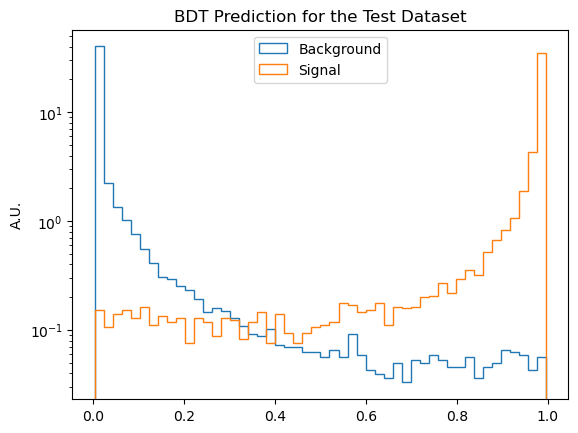

In [372]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
#plt.savefig(f'plots/BDT_inclusive_score.png')
plt.yscale('log')

[Text(0, 0, 'sel_vtx_projectedLxy'),
 Text(0, 1, 'sel_vtx_cos_collinear'),
 Text(0, 2, 'sel_vtx_prod_eta'),
 Text(0, 3, 'delta_dxy_over_maxdxy'),
 Text(0, 4, 'sel_vtx_chi2'),
 Text(0, 5, 'sel_vtx_pt_over_m'),
 Text(0, 6, 'sel_vtx_METdPhi'),
 Text(0, 7, 'vxy'),
 Text(0, 8, 'vxy_signif'),
 Text(0, 9, 'sel_vtx_dR'),
 Text(0, 10, 'sel_vtx_minDxy'),
 Text(0, 11, 'sel_vtx_m')]

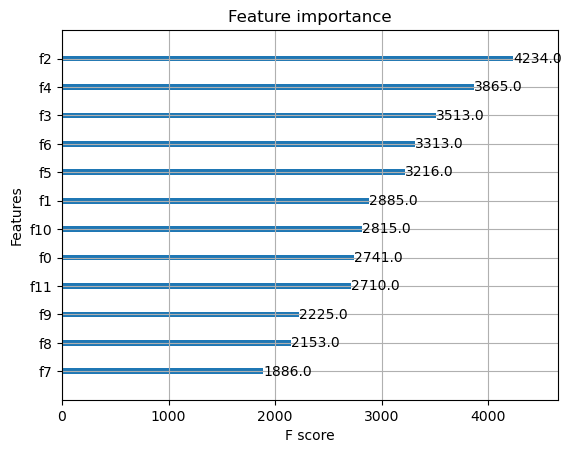

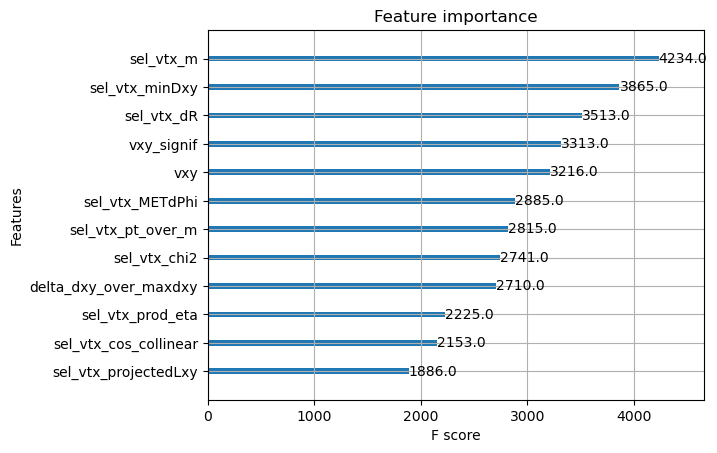

In [373]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
#plt.savefig(f'plots/BDT_inclusive_importance_bst.png', bbox_inches = "tight")

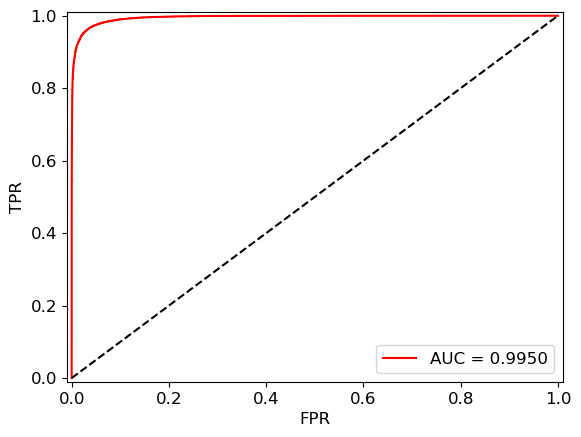

In [374]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig(f'plots/BDT_inclusive_roc_curve.png')

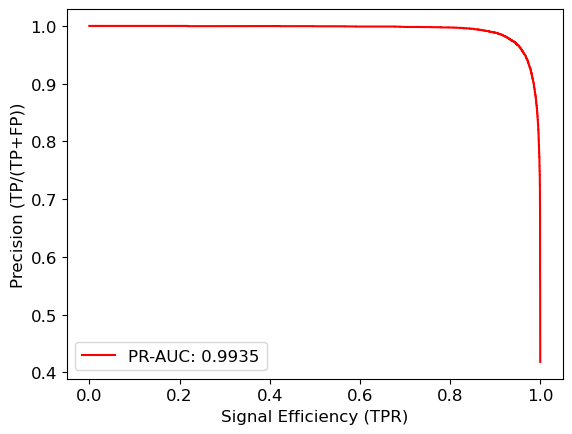

In [375]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, preds)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

In [376]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [377]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

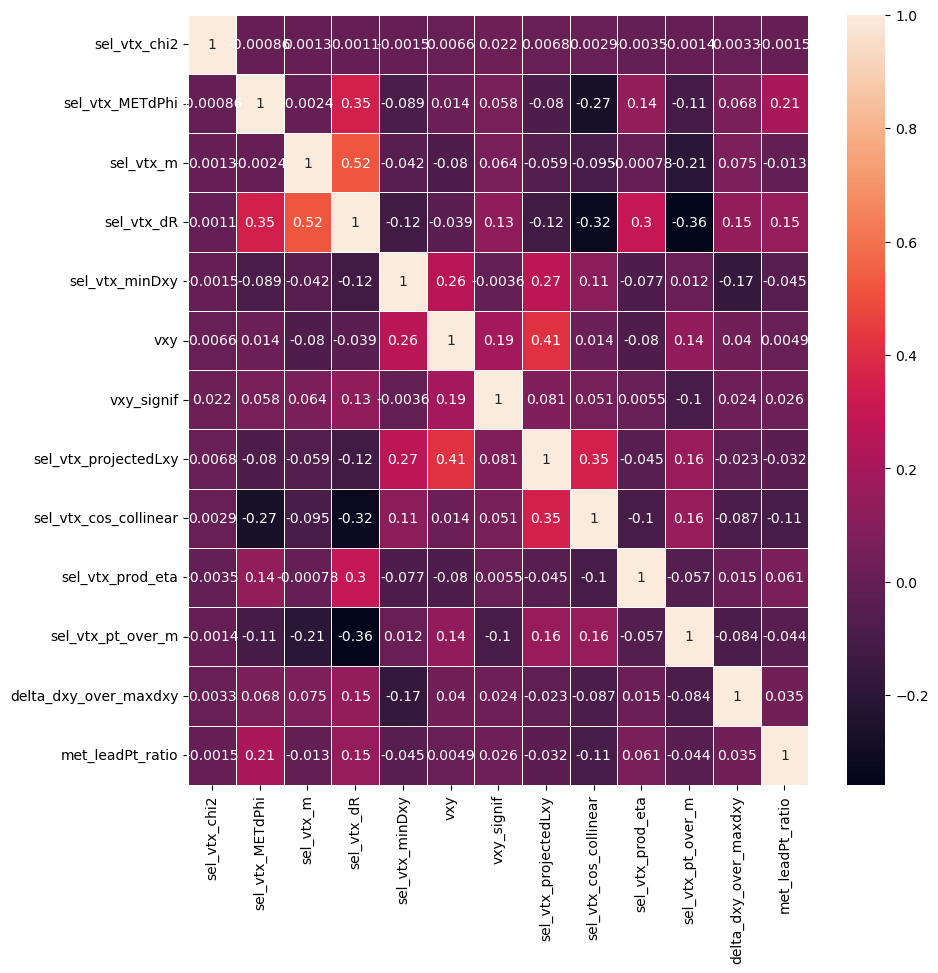

In [309]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

plt.savefig('sig_correlation.png')

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 76447)')

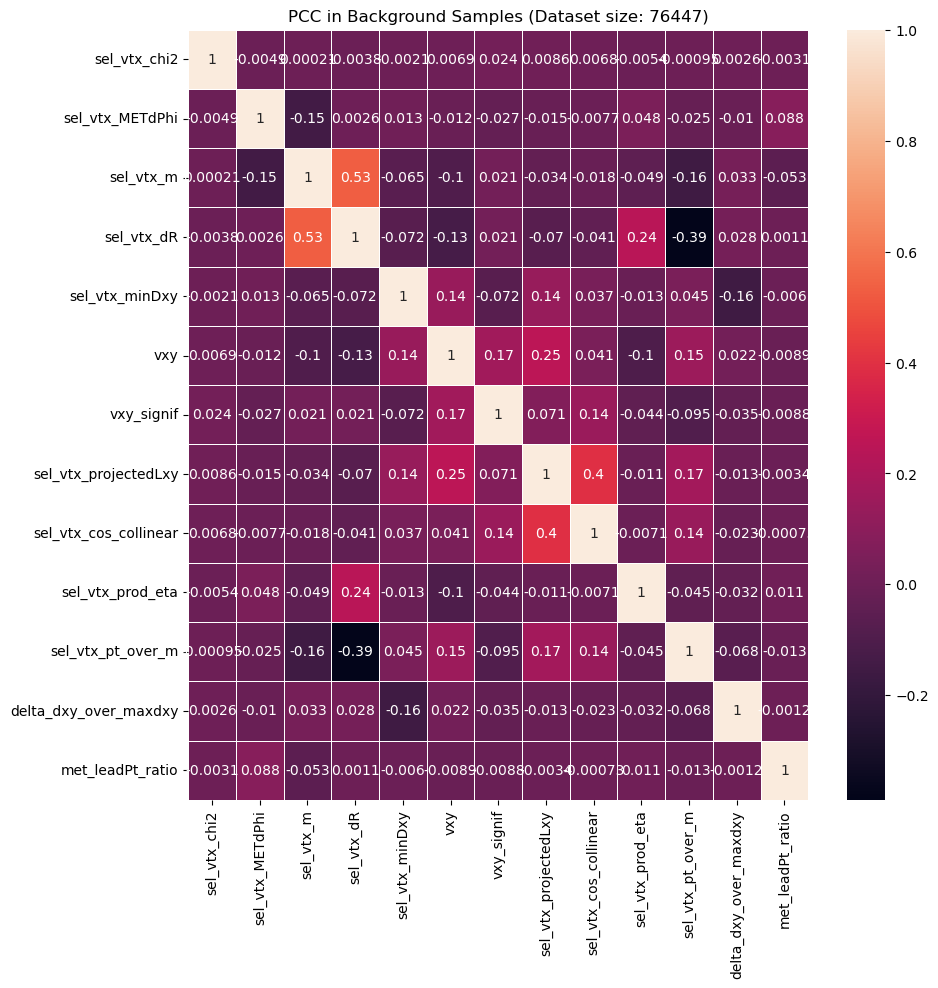

In [307]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 54961)')

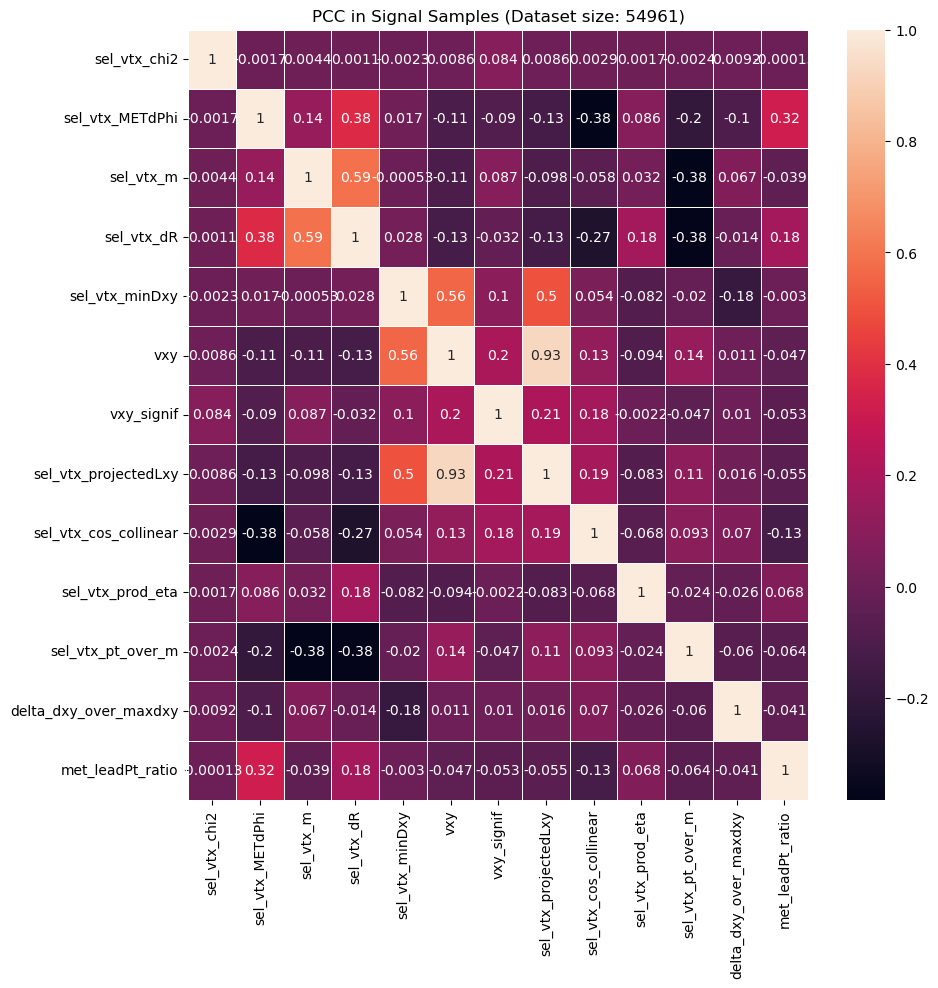

In [308]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')

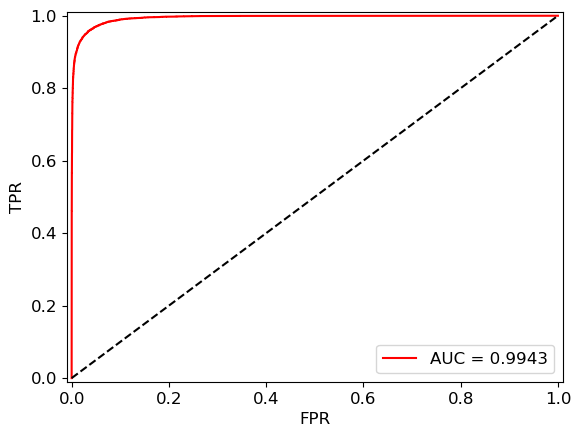

In [222]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig(f'plots/BDT_inclusive_roc_curve.png')

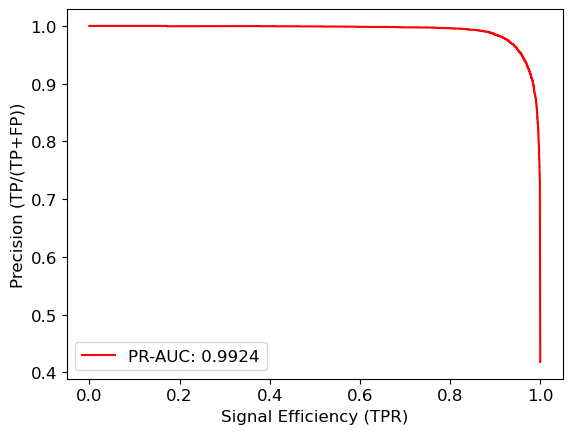

In [223]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, preds)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

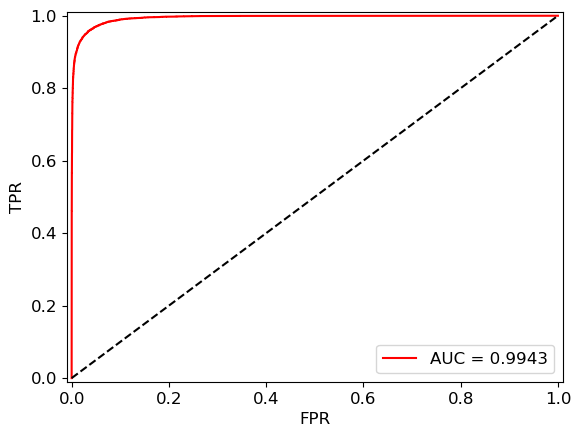

In [224]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig(f'plots/BDT_inclusive_roc_curve.png')

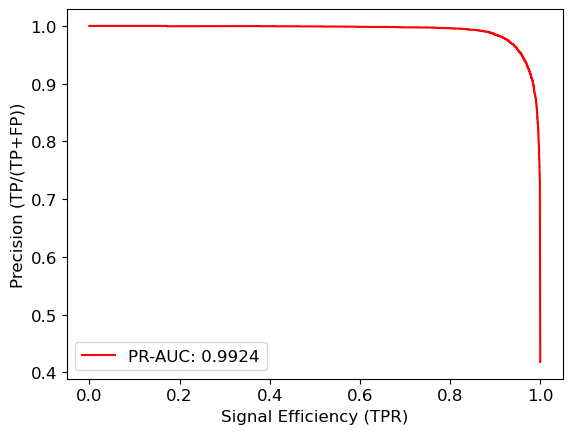

In [225]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, preds)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

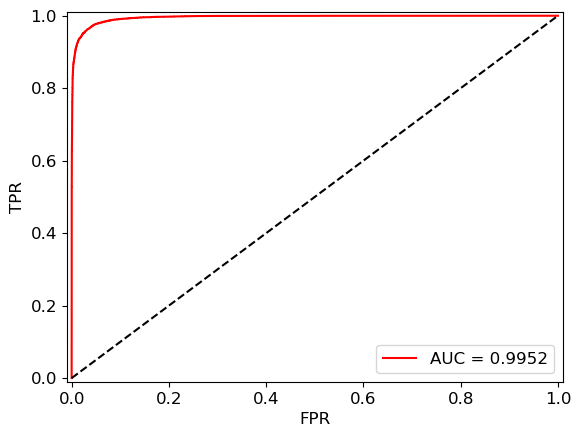

In [35]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig(f'plots/BDT_inclusive_roc_curve.png')

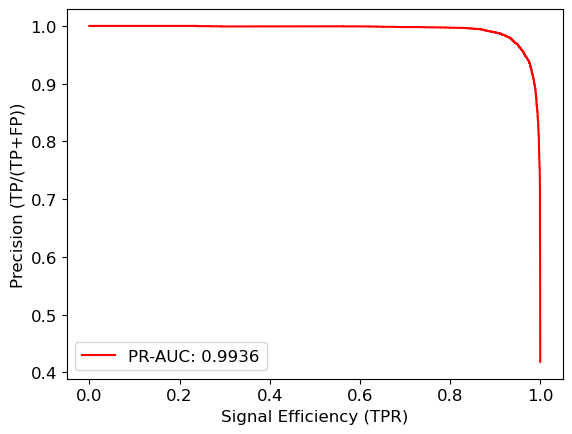

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, preds)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

### Save and load

In [378]:
os.system(f'mkdir -p models')

0

In [379]:
bst.save_model(f'models/BDTv4.json')

In [380]:
trained_model = xgb.XGBRegressor()
trained_model.load_model(f'models/BDTv4.json')

In [381]:
prediction = trained_model.predict(test)

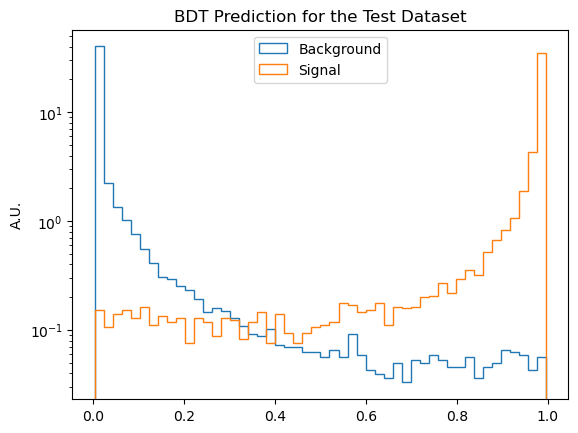

In [382]:
bins = 50

h_bkg,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h_sig,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.yscale('log')

In [383]:
h_sig = h_sig[::-1]
h_sig

array([34.66330223,  4.28528225,  1.89935332,  1.07864834,  0.83243513,
        0.66829299,  0.51587374,  0.31655984,  0.35759537,  0.29311096,
        0.21690211,  0.26966127,  0.20517767,  0.19931545,  0.16414214,
        0.15827944,  0.16414214,  0.11138217,  0.17586658,  0.1524177 ,
        0.14655504,  0.17000436,  0.17586658,  0.11724438,  0.111382  ,
        0.10551995,  0.09379537,  0.07620885,  0.09379537,  0.14069326,
        0.07620874,  0.14655548,  0.11724421,  0.08207107,  0.1231066 ,
        0.12896863,  0.08793329,  0.11724421,  0.12896882,  0.07620879,
        0.12896873,  0.1172443 ,  0.13483094,  0.11138208,  0.16414201,
        0.12896877,  0.15241759,  0.14069316,  0.10551988,  0.1524176 ])

In [384]:
h_bkg = h_bkg[::-1]
h_bkg

array([5.60142906e-02, 4.28344575e-02, 5.93090708e-02, 6.26042071e-02,
       6.58991654e-02, 4.94243741e-02, 4.61292773e-02, 3.62445410e-02,
       5.60142906e-02, 4.61294158e-02, 4.61294158e-02, 5.27191740e-02,
       5.93092489e-02, 4.94243741e-02, 5.27193323e-02, 3.29494838e-02,
       4.94243741e-02, 3.62445410e-02, 3.95394992e-02, 4.28344575e-02,
       5.93090708e-02, 9.22588316e-02, 5.60142906e-02, 6.58991654e-02,
       5.60142065e-02, 6.26042071e-02, 6.26041131e-02, 6.91941237e-02,
       6.91940198e-02, 7.24890820e-02, 1.02143553e-01, 8.89638733e-02,
       9.22586931e-02, 1.08733623e-01, 1.28503373e-01, 1.48272900e-01,
       1.58157997e-01, 1.44977946e-01, 1.91107580e-01, 2.33941862e-01,
       2.53711596e-01, 2.96546022e-01, 3.06430889e-01, 4.11869475e-01,
       5.53552574e-01, 7.54545161e-01, 1.02143630e+00, 1.35422683e+00,
       2.25045502e+00, 4.01325654e+01])

In [385]:
# S/B scan on the score (xsec unweighted)
h_sig_sum = []
h_bkg_sum = []

for idx, entry in enumerate(h_sig):
    integral = 0
    for j in range(idx):
        integral += h_sig[j]
    h_sig_sum.append(integral)

for idx, entry in enumerate(h_bkg):
    integral = 0
    for j in range(idx):
        integral += h_bkg[j]
    h_bkg_sum.append(integral)

np.array(h_sig_sum)/np.array(h_bkg_sum)

/tmp/ipykernel_2136/326739833.py:17: RuntimeWarning: invalid value encountered in divide
  np.array(h_sig_sum)/np.array(h_bkg_sum)


array([         nan, 618.82962121, 394.02203087, 258.27327471,
       189.9175637 , 149.16222547, 129.21505331, 114.96986272,
       105.76832438,  94.03544522,  86.26620745,  79.62725945,
        73.28580909,  67.18447291,  62.89815313,  58.86205658,
        56.67346419,  53.61893616,  51.58228841,  49.59768013,
        47.58924947,  45.0192307 ,  41.50485871,  39.69818679,
        37.70768489,  36.18199066,  34.61020756,  33.16725565,
        31.693768  ,  30.36091817,  29.1104361 ,  27.45451544,
        26.20578128,  25.01435067,  23.72102915,  22.371852  ,
        20.9954775 ,  19.68909094,  18.64413955,  17.42231131,
        16.10861538,  14.90859341,  13.71135205,  12.66892366,
        11.48495764,  10.21233977,   8.86445867,   7.52431776,
         6.2677068 ,   4.90152701])

[Text(0, 0, 'sel_vtx_projectedLxy'),
 Text(0, 1, 'sel_vtx_cos_collinear'),
 Text(0, 2, 'sel_vtx_prod_eta'),
 Text(0, 3, 'delta_dxy_over_maxdxy'),
 Text(0, 4, 'sel_vtx_chi2'),
 Text(0, 5, 'sel_vtx_pt_over_m'),
 Text(0, 6, 'sel_vtx_METdPhi'),
 Text(0, 7, 'vxy'),
 Text(0, 8, 'vxy_signif'),
 Text(0, 9, 'sel_vtx_dR'),
 Text(0, 10, 'sel_vtx_minDxy'),
 Text(0, 11, 'sel_vtx_m')]

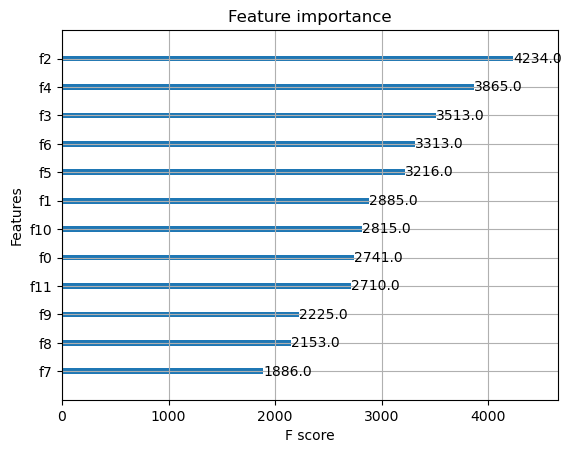

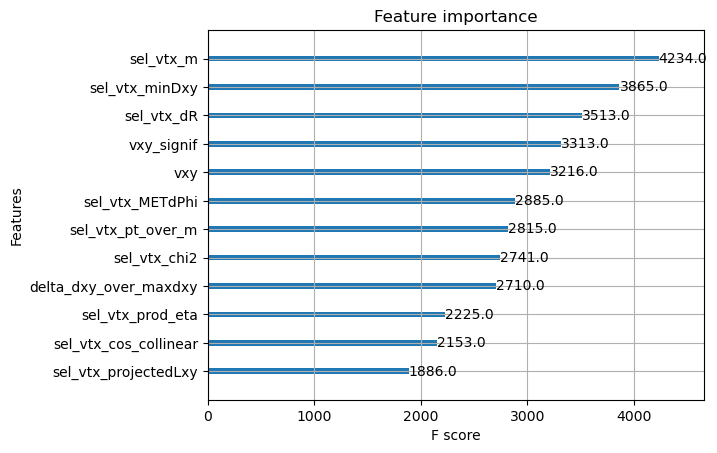

In [386]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

Text(0.5, 1.0, 'ROC')

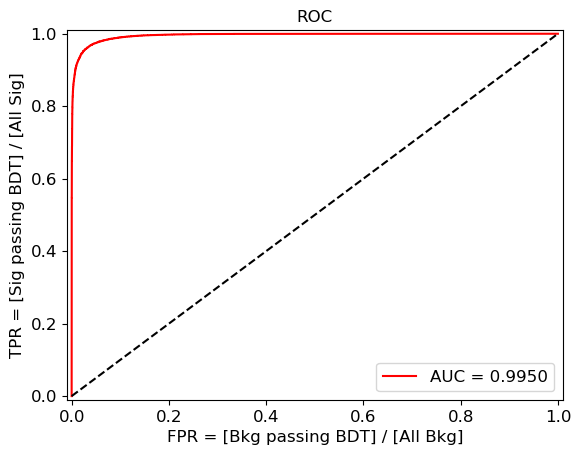

In [387]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR = [Bkg passing BDT] / [All Bkg]' , fontsize=12)
plt.ylabel('TPR = [Sig passing BDT] / [All Sig]' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)

plt.title('ROC')
#plt.savefig('plots/roc_curve_weighted_training.png')

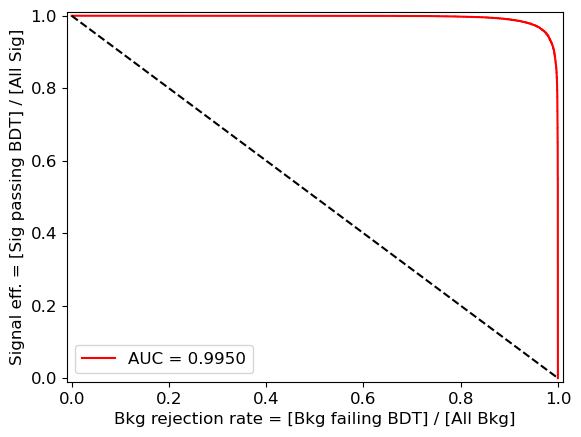

In [388]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(1-fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [1,0] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('Bkg rejection rate = [Bkg failing BDT] / [All Bkg]' , fontsize=12)
plt.ylabel('Signal eff. = [Sig passing BDT] / [All Sig]' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig('plots/roc_curve_weighted_training.png')

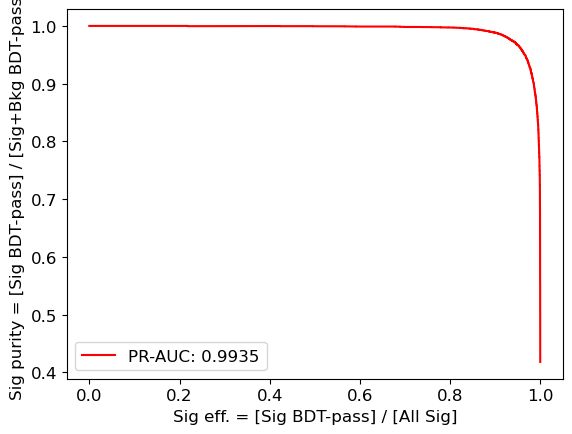

In [389]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, preds)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Sig purity = [Sig BDT-pass] / [Sig+Bkg BDT-pass]', fontsize=12)
plt.xlabel('Sig eff. = [Sig BDT-pass] / [All Sig]', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

In [390]:
def get_roc(y_true, y_pred, thres):
    FP = np.count_nonzero((y_true == 0) & (y_pred >= thres))
    TP = np.count_nonzero((y_true == 1) & (y_pred >= thres))
    
    FN = np.count_nonzero((y_true == 1) & (y_pred < thres))
    TN = np.count_nonzero((y_true == 0) & (y_pred < thres))
    
    FPR = FP/(FP+TN)
    TPR = TP/(TP+FN)
    
    s_over_sqrtB = TP/np.sqrt(FP)
    print(f'thres = {thres}, TPR = {TPR}, FPR = {FPR}, s_over_sqrtB = {s_over_sqrtB}')
    
    return TPR, FPR, s_over_sqrtB

In [391]:
def get_roc_auc(y_true, y_pred):
    s_over_sqrtBs = []
    TPRs = []
    FPRs = []
    
    epsilon = 0.005
    scan_range = np.linspace(0+epsilon,1-epsilon,10000)
    for thres in scan_range:
        TPR, FPR, s_over_sqrtB = get_roc(y_true, y_pred, thres)
        TPRs.append(TPR)
        FPRs.append(FPR)
        s_over_sqrtBs.append(s_over_sqrtB)
        
    return TPRs, FPRs, s_over_sqrtBs

In [392]:
TPRs, FPRs, s_over_sqrtBs = (get_roc_auc(y_test, preds))

thres = 0.005, TPR = 0.9995451651050669, FPR = 0.4053629823413996, s_over_sqrtB = 139.5702526946119
thres = 0.005099009900990099, TPR = 0.9995451651050669, FPR = 0.3985611510791367, s_over_sqrtB = 140.75616504448695
thres = 0.005198019801980198, TPR = 0.9995451651050669, FPR = 0.39149771092217134, s_over_sqrtB = 142.02025709263285
thres = 0.005297029702970297, TPR = 0.9995451651050669, FPR = 0.38737737083060825, s_over_sqrtB = 142.77355862594038
thres = 0.0053960396039603965, TPR = 0.9995451651050669, FPR = 0.3841726618705036, s_over_sqrtB = 143.36781937002425
thres = 0.005495049504950495, TPR = 0.9995451651050669, FPR = 0.37809025506867233, s_over_sqrtB = 144.51641051382856
thres = 0.005594059405940594, TPR = 0.9995451651050669, FPR = 0.37410071942446044, s_over_sqrtB = 145.2849527050805
thres = 0.005693069306930693, TPR = 0.9995451651050669, FPR = 0.36945716154349245, s_over_sqrtB = 146.19511572041756
thres = 0.005792079207920792, TPR = 0.9995451651050669, FPR = 0.3659254414650098, s

In [393]:
FPRs = [ 1-FPR for FPR in FPRs ]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


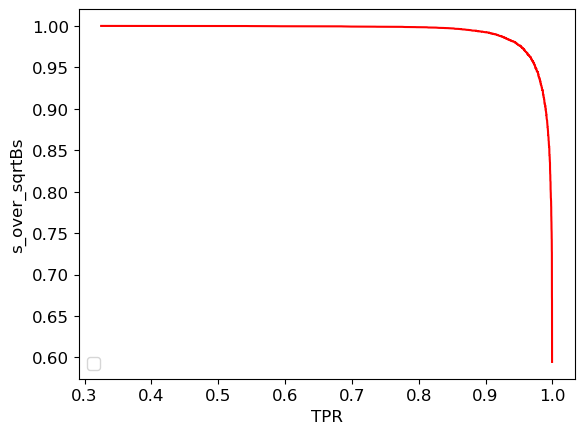

In [394]:
from sklearn.metrics import auc

plt.plot(TPRs, FPRs, color = "red")

plt.ylabel('s_over_sqrtBs', fontsize=12)
plt.xlabel('TPR', fontsize=12)

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

### WP

In [395]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [396]:
tpr_WP = {'tight': 0.7, 'medium': 0.85, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [397]:
epsilon = 0.005

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9830024838447571
medium threshold: 0.937138557434082
loose threshold: 0.8547812104225159
